# Short Term Water Demand Forecasting with Statistical and AI Methods

### Oscar Wooding
Department of Civil and Environmental Engineering, Imperial College London

### Introduction

Analysis of different AI techniques for short term water demand forecasting for the 

In [70]:
# imports 
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import matplotlib_inline
from datetime import datetime
import warnings
from scipy import stats
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt

%matplotlib inline

# imports for time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# imports for time series forecasting
#from sktime.forecasting.base import ForecastingHorizon
#from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
#from sktime.forecasting.naive import NaiveForecaster

# improve matlab output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

rc('text', usetex=False)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# adjust the format of the data set
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'Holidays'

### Load Data

In [40]:
# load inflow data
inflow_data = pd.read_csv("../data/InflowData.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('date_time')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
inflow_data.head(3)

,dma_a,dma_b,dma_c,dma_d,dma_e,dma_f,dma_g,dma_h,dma_i,dma_j
date_time,,,,,,,,,,
2021-01-01 00:00:00,NaN,NaN,3.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,NaN,NaN,3.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00,NaN,NaN,3.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# load weather data
weather_data = pd.read_csv("../data/WeatherData.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('date_time')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
weather_data.head(3)

,rain_depth,air_temp,air_humid,windspeed
date_time,,,,
2021-01-01 00:00:00,0.00,7.20,79.00,9.00
2021-01-01 01:00:00,0.00,7.30,79.00,6.00
2021-01-01 02:00:00,0.00,7.60,78.00,4.00


In [57]:
# clean data

# remove dupes
inflow_data = inflow_data[~inflow_data.index.duplicated(keep='first')]
weather_data = weather_data[~weather_data.index.duplicated(keep='first')]

# set frequency
inflow_data = inflow_data.asfreq(pd.offsets.Hour(), method='pad')
weather_data = weather_data.asfreq(pd.offsets.Hour(), method='pad')

# fill missing using ...
inflow_data_imputed = inflow_data.interpolate(limit=8, method='linear', limit_direction='both') #.bfill()
weather_data_imputed = weather_data.interpolate(limit=8, method='linear', limit_direction='both') #.bfill()

temp_mode = 0 # What default value to take?No
inflow_data_imputed['dma_a'] = inflow_data_imputed['dma_a'].fillna(temp_mode)
inflow_data_imputed['dma_a'].isnull().sum()

# normalisation
# prepare data for normalization
values = inflow_data_imputed['dma_a'].values
values = values.reshape((len(values), 1))
 
# train the normalization
scaler_norm = MinMaxScaler(feature_range=(0, 1))
scaler_norm = scaler_norm.fit(values)
print('Min: %f, Max: %f' % (scaler_norm.data_min_, scaler_norm.data_max_))

# standardisation
# prepare data for standardization
values = inflow_data_imputed['dma_a'].values
values = values.reshape((len(values), 1))
 
# train the standardization
scaler_std = StandardScaler()
scaler_std = scaler_std.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler_std.mean_, sqrt(scaler_std.var_)))

Min: 0.000000, Max: 29.750000
Mean: 8.208821, StandardDeviation: 3.087574


In [58]:
# normalize the data set and print the first 5 rows
normalized = scaler_norm.transform(values)
print('Normalised Values \n')
for i in range(5):
    print(normalized[-i])
 
# standardization the data set and print the first 5 rows
print('\nStandardised Values')
standardized = scaler_std.transform(values)
for i in range(5):
    print(standardized[-i])
    
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
print('\nIntitial Values')
for i in range(5):
    print(inversed[-i])
    

Normalised Values 

[0.]
[0.39]
[0.35]
[0.39]
[0.43]

Standardised Values
[-2.66]
[1.08]
[0.72]
[1.09]
[1.5]

Intitial Values
[0.]
[11.53]
[10.42]
[11.56]
[12.84]


In [16]:
# understanding data
print('Missing Values\n')
print(weather_data_imputed.isna().sum())
print(inflow_data_imputed.isna().sum())

print('\nValue Counts\n')
print(len(weather_data_imputed))
print(len(inflow_data_imputed))

print('\nStatistical Descriptors\n')
print(weather_data_imputed.describe(),'\n')
print(inflow_data_imputed.describe())

Missing Values

rain_depth    0
air_temp      0
air_humid     0
windspeed     0
dtype: int64
dma_a    0
dma_b    0
dma_c    0
dma_d    0
dma_e    0
dma_f    0
dma_g    0
dma_h    0
dma_i    0
dma_j    0
dtype: int64

Value Counts

13848
13680

Statistical Descriptors

       rain_depth  air_temp  air_humid  windspeed
count   13,848.00 13,848.00  13,848.00  13,848.00
mean         0.06     15.53      63.63      13.90
std          0.54      7.51      15.46      12.31
min          0.00     -2.10      17.00       1.00
25%          0.00      9.00      53.00       5.00
50%          0.00     14.20      63.00       9.00
75%          0.00     22.50      74.00      18.00
max         28.10     34.60     100.00      77.00 

          dma_a     dma_b     dma_c     dma_d     dma_e     dma_f     dma_g  \
count 13,680.00 13,680.00 13,680.00 13,680.00 13,680.00 13,680.00 13,680.00   
mean       8.42      9.58      4.50     33.59     77.58      8.10     24.40   
std        2.82      1.84      1.50      6

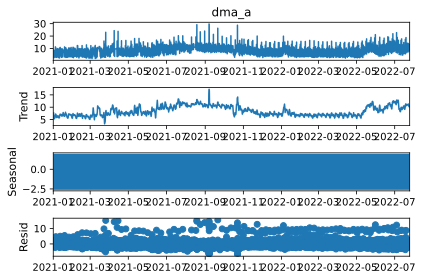

In [17]:
# Decompose time series (for dma_a)
decomposition = sm.tsa.seasonal_decompose(inflow_data_imputed['dma_a'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
plt.rcParams['figure.figsize'] = [10.0, 6.0]

In [19]:
load = inflow_data_imputed['2021-01':'2021-03']

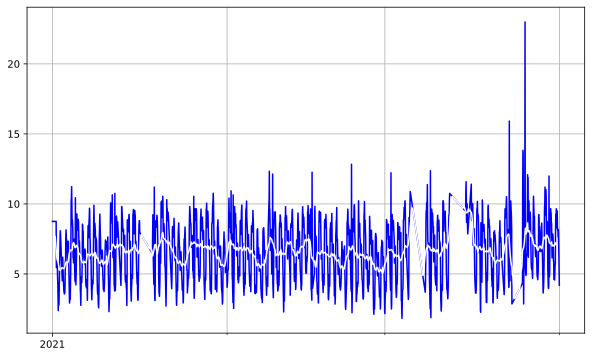

In [24]:
decomposition = sm.tsa.seasonal_decompose(load['dma_a'], model = 'additive')
 
fig, ax = plt.subplots()
ax.grid(True)
 
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)
 
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
 
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
 
plt.plot(load['dma_a'], c='blue')
plt.plot(decomposition.trend, c='white')

In [68]:
# creating features
# date time features
inflow_data_imputed['hour'] = [inflow_data_imputed.index[i].hour for i in range(len(inflow_data_imputed))]
inflow_data_imputed['month'] = [inflow_data_imputed.index[i].month for i in range(len(inflow_data_imputed))]
inflow_data_imputed['dayofweek'] = [inflow_data_imputed.index[i].day for i in range(len(inflow_data_imputed))]

inflow_data_imputed['weekend'] = [
    0 if inflow_data_imputed.index[i].day in range(5) 
    else 1 for i in range(len(inflow_data_imputed))
]

print(inflow_data_imputed.head(5))

                     dma_a  dma_b  dma_c  dma_d  dma_e  dma_f  dma_g  dma_h  \
date_time                                                                     
2021-01-01 00:00:00   0.00    NaN   3.70    NaN    NaN    NaN    NaN    NaN   
2021-01-01 01:00:00   0.00    NaN   3.56    NaN    NaN    NaN    NaN    NaN   
2021-01-01 02:00:00   0.00    NaN   3.27    NaN    NaN    NaN    NaN    NaN   
2021-01-01 03:00:00   0.00    NaN   2.84    NaN    NaN    NaN    NaN    NaN   
2021-01-01 04:00:00   0.00    NaN   2.74    NaN    NaN    NaN    NaN    NaN   

                     dma_i  dma_j  hour  month  dayofweek  weekend  
date_time                                                           
2021-01-01 00:00:00    NaN    NaN     0      1          1        0  
2021-01-01 01:00:00    NaN    NaN     1      1          1        0  
2021-01-01 02:00:00    NaN    NaN     2      1          1        0  
2021-01-01 03:00:00    NaN    NaN     3      1          1        0  
2021-01-01 04:00:00    NaN    Na

In [7]:
# PRACTICE CELL
import numpy as np
import datetime as dt
import pandas as pd

pd.Timestamp(dt.datetime(2014,5,1))
pd.Timestamp(2014,6,1)
pd.Period('2014-6', freq='D')

dates = [1, 2, 3]
pd.Series(np.random.randn(3), dates)

1   -1.10
2   -0.17
3   -0.93
dtype: float64

In [44]:
pd.to_datetime(['2014.14.6', '2015.12.7'], dayfirst=True, format='%Y.%d.%m')

DatetimeIndex(['2014-06-14', '2015-07-12'], dtype='datetime64[ns]', freq=None)

In [ ]:
daily_ts_data = ts_data.asfreq(pd.offsets.BDay())
daily_ts_data.head(5)